In [14]:
# Importar las bibliotecas necesarias
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from pathlib import Path

# Configurar MLflow para usar directorios locales
MLFLOW_TRACKING_URI = "http://localhost:5008"
ARTIFACT_ROOT = str(Path.cwd().parent / "mlruns")

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
os.environ["MLFLOW_ARTIFACT_ROOT"] = ARTIFACT_ROOT

# Crear el experimento
mlflow.set_experiment("Clasificador de documentos")

# Configurar el directorio de artefactos local
import os
os.environ['MLFLOW_TRACKING_URI'] = "http://localhost:5008"
os.environ['MLFLOW_DEFAULT_ARTIFACT_ROOT'] = "./mlruns"


2025/06/16 22:48:20 INFO mlflow.tracking.fluent: Experiment with name 'Clasificador de documentos' does not exist. Creating a new experiment.


In [15]:
import pandas as pd
import pickle
import numpy as np
from pathlib import Path

# Configuración de paths
DATA_PATH = Path("../data")
print(f"Directorio de datos: {DATA_PATH.absolute()}")
print(f"Archivos disponibles: {list(DATA_PATH.glob('*'))}")


Directorio de datos: /Users/mb/Documents/PoC/clasificador/notebooks/../data
Archivos disponibles: [PosixPath('../data/Insumos'), PosixPath('../data/preprocessed_corpus.csv'), PosixPath('../data/processed_corpus.pkl'), PosixPath('../data/splits'), PosixPath('../data/preprocessed_corpus.pkl')]


In [16]:
# Leer el corpus preprocesado desde CSV
corpus_csv_path = DATA_PATH / "preprocessed_corpus.csv"
print(f"Cargando corpus desde: {corpus_csv_path}")

# Cargar el corpus
df_corpus = pd.read_csv(corpus_csv_path)

print(f"Forma del dataset: {df_corpus.shape}")
print(f"Columnas disponibles: {list(df_corpus.columns)}")
print("\nPrimeras 5 filas:")
df_corpus.head()


Cargando corpus desde: ../data/preprocessed_corpus.csv
Forma del dataset: (344, 3)
Columnas disponibles: ['documento_original', 'tipo', 'texto_procesado']

Primeras 5 filas:


,documento_original,tipo,texto_procesado
0,o!\n\n(O) Tintorería Ecoloca\nN TACO\n\nPara: ...,Carta de trabajo,tintoreria ecoloca taco mercantil banco consta...
1,CICR\n\nCONSTANCIA DE TRABAJO\n\nA quien pueda...,Carta de trabajo,cicr constancia trabajo pueda interesar. suscr...
2,"Distribuidora Zoliannys, LLC.\n\nEIN 30-130830...",Carta de trabajo,distribuidora zoliannys llc. ein 30-1308305 fl...
3,CONSTANCIA\n\nAla atención de Banco Mercantil ...,Carta de trabajo,constancia ala atencion banco mercantil panama...
4,"Ave. Samuel Lewis y Calle 58, Obarrio , Torre ...",Carta de trabajo,ave. samuel lewis calle obarrio torre adr piso...


In [17]:
# Información adicional del corpus
print("=== INFORMACIÓN DEL CORPUS ===")
print(f"Número total de documentos: {len(df_corpus)}")
print(f"Información de tipos de datos:")
print(df_corpus.dtypes)
print(f"\nInformación de valores nulos:")
print(df_corpus.isnull().sum())

if 'label' in df_corpus.columns or 'categoria' in df_corpus.columns or 'category' in df_corpus.columns:
    # Buscar la columna de etiquetas
    label_col = None
    for col in ['label', 'categoria', 'category', 'class', 'target']:
        if col in df_corpus.columns:
            label_col = col
            break
    
    if label_col:
        print(f"\n=== DISTRIBUCIÓN DE CLASES ===")
        print(f"Columna de etiquetas: '{label_col}'")
        print(df_corpus[label_col].value_counts())
        print(f"\nPorcentaje por clase:")
        print(df_corpus[label_col].value_counts(normalize=True) * 100)


=== INFORMACIÓN DEL CORPUS ===
Número total de documentos: 344
Información de tipos de datos:
documento_original    object
tipo                  object
texto_procesado       object
dtype: object

Información de valores nulos:
documento_original    0
tipo                  0
texto_procesado       0
dtype: int64


In [18]:
# Análisis de la distribución de clases en el corpus completo
print("=== DISTRIBUCIÓN DE CLASES EN EL CORPUS COMPLETO ===")
print(f"Columna de etiquetas: 'tipo'")
print(df_corpus['tipo'].value_counts())
print(f"\nPorcentaje por clase:")
print(df_corpus['tipo'].value_counts(normalize=True) * 100)


=== DISTRIBUCIÓN DE CLASES EN EL CORPUS COMPLETO ===
Columna de etiquetas: 'tipo'
tipo
Carta de trabajo        98
Sustento de ingresos    95
Pasaportes              91
Cedulas 2               41
W-9                     19
Name: count, dtype: int64

Porcentaje por clase:
tipo
Carta de trabajo        28.488372
Sustento de ingresos    27.616279
Pasaportes              26.453488
Cedulas 2               11.918605
W-9                      5.523256
Name: proportion, dtype: float64


In [19]:
# Cargar metadatos de división
import json
from sklearn.model_selection import train_test_split

# Cargar los metadatos de división
split_metadata_path = DATA_PATH / "splits" / "split_metadata.json"
with open(split_metadata_path, 'r') as f:
    split_metadata = json.load(f)

print("=== METADATOS DE DIVISIÓN ===")
for key, value in split_metadata.items():
    print(f"{key}: {value}")

# Verificar que los datos coinciden con los metadatos
print(f"\nVerificación:")
print(f"Total muestras en corpus: {len(df_corpus)}")
print(f"Total muestras esperadas: {split_metadata['total_samples']}")
print(f"Coinciden: {len(df_corpus) == split_metadata['total_samples']}")


=== METADATOS DE DIVISIÓN ===
total_samples: 344
train_samples: 260
test_samples: 84
train_percentage: 75.5813953488372
test_percentage: 24.418604651162788
classes: ['Carta de trabajo', 'Cedulas 2', 'Pasaportes', 'Sustento de ingresos', 'W-9']
min_test_samples_used: 5
target_test_ratio_used: 0.25
random_state: 42
split_strategy: stratified_with_minimum_test_samples

Verificación:
Total muestras en corpus: 344
Total muestras esperadas: 344
Coinciden: True


In [20]:
# Ejecutar la división estratificada según los metadatos
def stratified_split_with_minimum_test_samples(df, target_col, test_size=0.25, min_test_samples=5, random_state=42):
    """
    División estratificada que garantiza un mínimo de muestras de prueba por clase
    """
    # Calcular las muestras de prueba por clase
    class_counts = df[target_col].value_counts()
    
    # Para clases con pocas muestras, usar el mínimo especificado
    # Para clases con muchas muestras, usar el porcentaje objetivo
    test_samples_per_class = {}
    
    for class_name, count in class_counts.items():
        # Calcular muestras de prueba basadas en el porcentaje objetivo
        target_test_samples = int(count * test_size)
        # Usar el máximo entre el mínimo requerido y el objetivo
        test_samples_per_class[class_name] = max(min_test_samples, target_test_samples)
    
    print("Muestras de prueba por clase:")
    for class_name, test_samples in test_samples_per_class.items():
        total_samples = class_counts[class_name]
        percentage = (test_samples / total_samples) * 100
        print(f"  {class_name}: {test_samples}/{total_samples} ({percentage:.2f}%)")
    
    # Realizar la división
    train_indices = []
    test_indices = []
    
    for class_name in class_counts.index:
        class_indices = df[df[target_col] == class_name].index.tolist()
        n_test = test_samples_per_class[class_name]
        
        # División aleatoria para esta clase
        train_class, test_class = train_test_split(
            class_indices, 
            test_size=n_test, 
            random_state=random_state
        )
        
        train_indices.extend(train_class)
        test_indices.extend(test_class)
    
    return train_indices, test_indices

# Ejecutar la división
print("\\n=== EJECUTANDO DIVISIÓN DE DATOS ===")
train_indices, test_indices = stratified_split_with_minimum_test_samples(
    df_corpus, 
    target_col='tipo',
    test_size=split_metadata['target_test_ratio_used'],
    min_test_samples=split_metadata['min_test_samples_used'],
    random_state=split_metadata['random_state']
)

# Crear los conjuntos de entrenamiento y prueba
train_df = df_corpus.iloc[train_indices].copy()
test_df = df_corpus.iloc[test_indices].copy()

print(f"\\nTamaños de los conjuntos:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")
print(f"Total: {len(train_df) + len(test_df)} muestras")


\n=== EJECUTANDO DIVISIÓN DE DATOS ===
Muestras de prueba por clase:
  Carta de trabajo: 24/98 (24.49%)
  Sustento de ingresos: 23/95 (24.21%)
  Pasaportes: 22/91 (24.18%)
  Cedulas 2: 10/41 (24.39%)
  W-9: 5/19 (26.32%)
\nTamaños de los conjuntos:
Entrenamiento: 260 muestras
Prueba: 84 muestras
Total: 344 muestras


In [21]:
# Verificar la distribución de clases en los conjuntos
print("=== DISTRIBUCIÓN DE CLASES EN CONJUNTO DE ENTRENAMIENTO ===")
train_distribution = train_df['tipo'].value_counts()
print(train_distribution)
print(f"\\nPorcentajes:")
print((train_distribution / len(train_df) * 100).round(2))

print("\\n=== DISTRIBUCIÓN DE CLASES EN CONJUNTO DE PRUEBA ===")
test_distribution = test_df['tipo'].value_counts()
print(test_distribution)
print(f"\\nPorcentajes:")
print((test_distribution / len(test_df) * 100).round(2))

# Verificar que coincide con los metadatos esperados
print("\\n=== VERIFICACIÓN CON METADATOS ===")
print(f"Muestras de entrenamiento esperadas: {split_metadata['train_samples']}")
print(f"Muestras de entrenamiento obtenidas: {len(train_df)}")
print(f"Coinciden: {len(train_df) == split_metadata['train_samples']}")

print(f"\\nMuestras de prueba esperadas: {split_metadata['test_samples']}")
print(f"Muestras de prueba obtenidas: {len(test_df)}")
print(f"Coinciden: {len(test_df) == split_metadata['test_samples']}")


=== DISTRIBUCIÓN DE CLASES EN CONJUNTO DE ENTRENAMIENTO ===
tipo
Carta de trabajo        74
Sustento de ingresos    72
Pasaportes              69
Cedulas 2               31
W-9                     14
Name: count, dtype: int64
\nPorcentajes:
tipo
Carta de trabajo        28.46
Sustento de ingresos    27.69
Pasaportes              26.54
Cedulas 2               11.92
W-9                      5.38
Name: count, dtype: float64
\n=== DISTRIBUCIÓN DE CLASES EN CONJUNTO DE PRUEBA ===
tipo
Carta de trabajo        24
Sustento de ingresos    23
Pasaportes              22
Cedulas 2               10
W-9                      5
Name: count, dtype: int64
\nPorcentajes:
tipo
Carta de trabajo        28.57
Sustento de ingresos    27.38
Pasaportes              26.19
Cedulas 2               11.90
W-9                      5.95
Name: count, dtype: float64
\n=== VERIFICACIÓN CON METADATOS ===
Muestras de entrenamiento esperadas: 260
Muestras de entrenamiento obtenidas: 260
Coinciden: True
\nMuestras de prueba e

In [22]:
# Preparar los datos para el entrenamiento
print("=== PREPARACIÓN DE DATOS PARA ENTRENAMIENTO ===")

# Extraer características y etiquetas
X_train = train_df['texto_procesado'].values
y_train = train_df['tipo'].values

X_test = test_df['texto_procesado'].values  
y_test = test_df['tipo'].values

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

# Mostrar algunos ejemplos de datos de entrenamiento
print("\\n=== EJEMPLOS DE DATOS DE ENTRENAMIENTO ===")
for i in range(3):
    print(f"\\nEjemplo {i+1}:")
    print(f"Clase: {y_train[i]}")
    print(f"Texto (primeros 200 caracteres): {X_train[i][:200]}...")

# Guardar los índices para reproducibilidad
split_info = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'train_size': len(train_indices),
    'test_size': len(test_indices),
    'random_state': split_metadata['random_state']
}

print(f"\\n=== INFORMACIÓN DE DIVISIÓN GUARDADA ===")
print(f"Índices de entrenamiento: {len(split_info['train_indices'])} muestras")
print(f"Índices de prueba: {len(split_info['test_indices'])} muestras")
print(f"Estado aleatorio usado: {split_info['random_state']}")


=== PREPARACIÓN DE DATOS PARA ENTRENAMIENTO ===
Forma de X_train: (260,)
Forma de y_train: (260,)
Forma de X_test: (84,)
Forma de y_test: (84,)
\n=== EJEMPLOS DE DATOS DE ENTRENAMIENTO ===
\nEjemplo 1:
Clase: Carta de trabajo
Texto (primeros 200 caracteres): scanned tapscanner...
\nEjemplo 2:
Clase: Carta de trabajo
Texto (primeros 200 caracteres): rif j-4 valencia septiembre 2023 referencia laboral hacemos constar gustavo adolfo jesus quero miquilena titular cedula identidad nro. v-21.448.232 presta servicios empresa honorarios profesionales di...
\nEjemplo 3:
Clase: Carta de trabajo
Texto (primeros 200 caracteres): medio presente hace constar joseph reinaldo moreno silvera titular cedula identidad v-25.037.129 labora actualmente empresa julio 2021 desempenando cargo consultor senior devengando actualmente concep...
\n=== INFORMACIÓN DE DIVISIÓN GUARDADA ===
Índices de entrenamiento: 260 muestras
Índices de prueba: 84 muestras
Estado aleatorio usado: 42


In [23]:
# Importar librerías para entrenamiento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

print("=== CONFIGURACIÓN DE VECTORIZACIÓN ===")
# Configurar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitar a las 5000 palabras más importantes
    ngram_range=(1, 2),  # Usar unigramas y bigramas
    min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
    max_df=0.95,  # Ignorar términos que aparecen en más del 95% de documentos
    stop_words=None,  # Ya fueron removidas en el preprocesamiento
    lowercase=False  # Ya está en minúsculas
)

print(f"Configuración TF-IDF:")
print(f"  - Max features: {tfidf_vectorizer.max_features}")
print(f"  - N-gram range: {tfidf_vectorizer.ngram_range}")
print(f"  - Min DF: {tfidf_vectorizer.min_df}")
print(f"  - Max DF: {tfidf_vectorizer.max_df}")

# Vectorizar los datos
print(f"\nVectorizando los datos...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Forma de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")
print(f"Vocabulario construido: {len(tfidf_vectorizer.vocabulary_)} términos únicos")


=== CONFIGURACIÓN DE VECTORIZACIÓN ===
Configuración TF-IDF:
  - Max features: 5000
  - N-gram range: (1, 2)
  - Min DF: 2
  - Max DF: 0.95

Vectorizando los datos...
Forma de X_train_tfidf: (260, 3278)
Forma de X_test_tfidf: (84, 3278)
Vocabulario construido: 3278 términos únicos


In [24]:
# Definir y entrenar múltiples modelos
print("=== ENTRENAMIENTO DE MODELOS ===")

modelos = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ),
    'SVM': SVC(
        kernel='linear',
        random_state=42,
        class_weight='balanced',
        probability=True
    ),
    'Naive Bayes': MultinomialNB(
        alpha=1.0
    )
}

# Entrenar y evaluar cada modelo
resultados = {}

for nombre_modelo, modelo in modelos.items():
    print(f"\n--- Entrenando {nombre_modelo} ---")

    # Al iniciar la corrida, ahora se registrará bajo el experimento definido arriba.
    with mlflow.start_run(run_name=nombre_modelo):
        # Registrar los parámetros del modelo
        if hasattr(modelo, 'get_params'):
            mlflow.log_params(modelo.get_params())

        # Entrenar el modelo
        modelo.fit(X_train_tfidf, y_train)

        # Hacer predicciones
        y_pred = modelo.predict(X_test_tfidf)

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # Registrar métricas en MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # AJUSTE 2: Guardar el modelo correctamente
        mlflow.sklearn.log_model(sk_model=modelo, artifact_path=nombre_modelo)

        # Guardar resultados locales
        resultados[nombre_modelo] = {
            'modelo': modelo,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'y_pred': y_pred
        }

        print(f"Métricas para {nombre_modelo}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

# Mostrar resumen de resultados
print(f"\n=== RESUMEN DE RESULTADOS ===")
for nombre_modelo, resultado in resultados.items():
    print(f"\n{nombre_modelo}:")
    print(f"  Accuracy: {resultado['accuracy']:.4f}")
    print(f"  Precision: {resultado['precision']:.4f}")
    print(f"  Recall: {resultado['recall']:.4f}")
    print(f"  F1 Score: {resultado['f1']:.4f}")

# Encontrar el mejor modelo basado en F1-Score
if resultados:
    mejor_modelo_nombre = max(resultados, key=lambda k: resultados[k]['f1'])
    mejor_modelo = resultados[mejor_modelo_nombre]

    print(f"\nMejor modelo: {mejor_modelo_nombre}")
    print(f"  F1 Score: {mejor_modelo['f1']:.4f}")
    print(f"  Accuracy: {mejor_modelo['accuracy']:.4f}")
    print(f"  Precision: {mejor_modelo['precision']:.4f}")
    print(f"  Recall: {mejor_modelo['recall']:.4f}")

=== ENTRENAMIENTO DE MODELOS ===

--- Entrenando Logistic Regression ---


/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Métricas para Logistic Regression:
  Accuracy: 0.9643
  Precision: 0.9725
  Recall: 0.9643
  F1 Score: 0.9659

--- Entrenando Random Forest ---


/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Métricas para Random Forest:
  Accuracy: 0.9286
  Precision: 0.9554
  Recall: 0.9286
  F1 Score: 0.9342

--- Entrenando SVM ---


/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Métricas para SVM:
  Accuracy: 0.9405
  Precision: 0.9410
  Recall: 0.9405
  F1 Score: 0.9389

--- Entrenando Naive Bayes ---
Métricas para Naive Bayes:
  Accuracy: 0.8929
  Precision: 0.9071
  Recall: 0.8929
  F1 Score: 0.8815

=== RESUMEN DE RESULTADOS ===

Logistic Regression:
  Accuracy: 0.9643
  Precision: 0.9725
  Recall: 0.9643
  F1 Score: 0.9659

Random Forest:
  Accuracy: 0.9286
  Precision: 0.9554
  Recall: 0.9286
  F1 Score: 0.9342

SVM:
  Accuracy: 0.9405
  Precision: 0.9410
  Recall: 0.9405
  F1 Score: 0.9389

Naive Bayes:
  Accuracy: 0.8929
  Precision: 0.9071
  Recall: 0.8929
  F1 Score: 0.8815

Mejor modelo: Logistic Regression
  F1 Score: 0.9659
  Accuracy: 0.9643
  Precision: 0.9725
  Recall: 0.9643


/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/qwen2-vl-finetuning/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


=== ANÁLISIS DETALLADO DEL MEJOR MODELO: Logistic Regression ===

Reporte de clasificación:
                      precision    recall  f1-score   support

    Carta de trabajo       1.00      1.00      1.00        24
           Cedulas 2       0.77      1.00      0.87        10
          Pasaportes       1.00      0.91      0.95        22
Sustento de ingresos       1.00      0.96      0.98        23
                 W-9       1.00      1.00      1.00         5

            accuracy                           0.96        84
           macro avg       0.95      0.97      0.96        84
        weighted avg       0.97      0.96      0.97        84


Matriz de confusión:
[[24  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  2 20  0  0]
 [ 0  1  0 22  0]
 [ 0  0  0  0  5]]


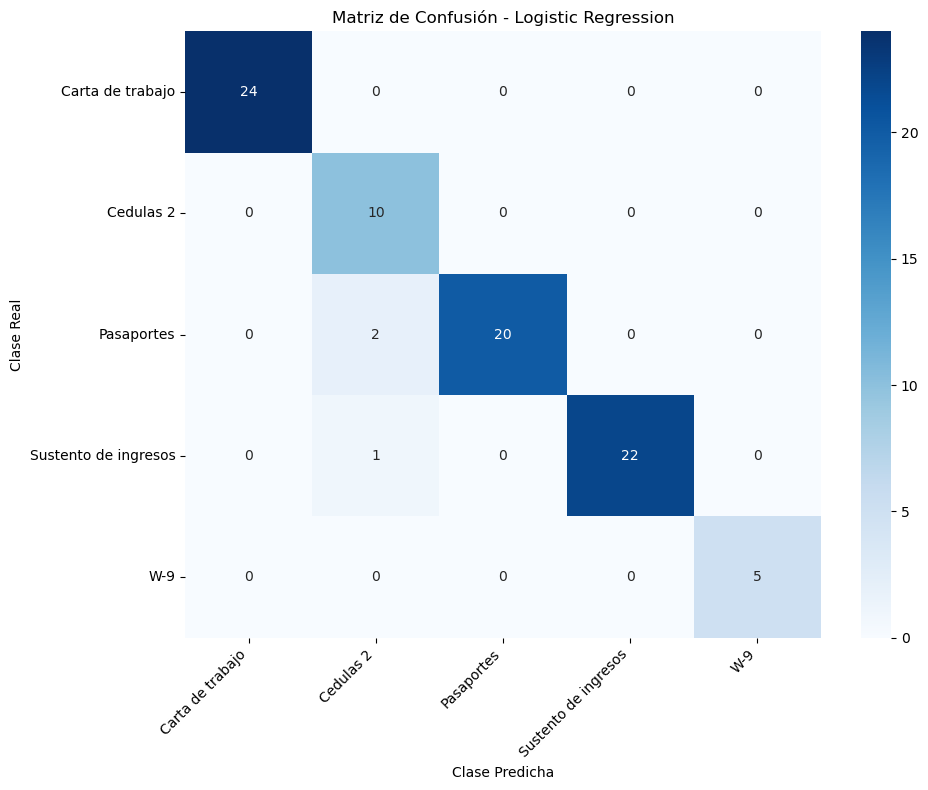


=== ANÁLISIS DE ERRORES POR CLASE ===
Carta de trabajo:
  Total muestras: 24
  Predicciones correctas: 24
  Accuracy: 1.0000

Cedulas 2:
  Total muestras: 10
  Predicciones correctas: 10
  Accuracy: 1.0000

Pasaportes:
  Total muestras: 22
  Predicciones correctas: 20
  Accuracy: 0.9091
  Errores más comunes: {'Cedulas 2': 2}

Sustento de ingresos:
  Total muestras: 23
  Predicciones correctas: 22
  Accuracy: 0.9565
  Errores más comunes: {'Cedulas 2': 1}

W-9:
  Total muestras: 5
  Predicciones correctas: 5
  Accuracy: 1.0000



In [25]:
# Análisis detallado del mejor modelo
print(f"=== ANÁLISIS DETALLADO DEL MEJOR MODELO: {mejor_modelo_nombre} ===")

# Reporte de clasificación detallado
print(f"\nReporte de clasificación:")
print(classification_report(y_test, mejor_modelo['y_pred'], target_names=split_metadata['classes']))

# Matriz de confusión
print(f"\nMatriz de confusión:")
cm = confusion_matrix(y_test, mejor_modelo['y_pred'])
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=split_metadata['classes'], 
            yticklabels=split_metadata['classes'])
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Análisis de errores por clase
print(f"\n=== ANÁLISIS DE ERRORES POR CLASE ===")
for i, clase in enumerate(split_metadata['classes']):
    # Índices de muestras de esta clase
    indices_clase = [j for j, label in enumerate(y_test) if label == clase]
    
    if indices_clase:
        # Predicciones para esta clase
        pred_clase = [mejor_modelo['y_pred'][j] for j in indices_clase]
        
        # Calcular accuracy para esta clase
        correctas = sum(1 for pred in pred_clase if pred == clase)
        total = len(pred_clase)
        accuracy_clase = correctas / total if total > 0 else 0
        
        print(f"{clase}:")
        print(f"  Total muestras: {total}")
        print(f"  Predicciones correctas: {correctas}")
        print(f"  Accuracy: {accuracy_clase:.4f}")
        
        # Mostrar errores específicos
        errores = [pred for pred in pred_clase if pred != clase]
        if errores:
            from collections import Counter
            conteo_errores = Counter(errores)
            print(f"  Errores más comunes: {dict(conteo_errores)}")
        print()


In [26]:
# Importar las bibliotecas necesarias
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5008")
mlflow.set_experiment("Clasificador de documentos")


<Experiment: artifact_location='/Users/mb/Documents/PoC/clasificador/mlruns_new/596689088583288250', creation_time=1750132100227, experiment_id='596689088583288250', last_update_time=1750132100227, lifecycle_stage='active', name='Clasificador de documentos', tags={}>

In [27]:
# Análisis de características más importantes (para modelos que lo soporten)
print("=== ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES ===")

if mejor_modelo_nombre in ['Logistic Regression', 'SVM']:
    # Para modelos lineales, podemos ver los coeficientes
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    if hasattr(mejor_modelo['modelo'], 'coef_'):
        coef = mejor_modelo['modelo'].coef_
        
        # Si es multiclase, mostrar para cada clase
        if len(coef) > 1:
            for i, clase in enumerate(split_metadata['classes']):
                print(f"\n--- Características más importantes para '{clase}' ---")
                
                # Obtener índices de características más importantes (positivas y negativas)
                clase_coef = coef[i]
                top_positive_idx = np.argsort(clase_coef)[-10:][::-1]  # Top 10 positivas
                top_negative_idx = np.argsort(clase_coef)[:10]  # Top 10 negativas
                
                print("Características que más indican esta clase:")
                for idx in top_positive_idx:
                    print(f"  {feature_names[idx]}: {clase_coef[idx]:.4f}")
                
                print("Características que más contraindican esta clase:")
                for idx in top_negative_idx:
                    print(f"  {feature_names[idx]}: {clase_coef[idx]:.4f}")

elif mejor_modelo_nombre == 'Random Forest':
    # Para Random Forest, podemos ver la importancia de características
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = mejor_modelo['modelo'].feature_importances_
    
    # Obtener las características más importantes
    top_indices = np.argsort(importances)[-20:][::-1]  # Top 20
    
    print("\\nCaracterísticas más importantes (Random Forest):")
    for i, idx in enumerate(top_indices):
        print(f"{i+1:2d}. {feature_names[idx]}: {importances[idx]:.6f}")

print(f"\\n=== ESTADÍSTICAS FINALES ===")
print(f"Modelo seleccionado: {mejor_modelo_nombre}")
print(f"Accuracy final: {mejor_modelo['accuracy']:.4f}")
print(f"Número de características utilizadas: {X_train_tfidf.shape[1]}")
print(f"Muestras de entrenamiento: {len(X_train)}")
print(f"Muestras de prueba: {len(X_test)}")
print(f"Número de clases: {len(set(y_train))}")


=== ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES ===

--- Características más importantes para 'Carta de trabajo' ---
Características que más indican esta clase:
  constancia: 1.0279
  presente: 0.8792
  constar: 0.6707
  mensual: 0.6683
  empresa: 0.6126
  caracas: 0.5926
  parte: 0.5742
  mercantil: 0.5689
  medio: 0.5656
  mil: 0.5469
Características que más contraindican esta clase:
  ingresos: -0.6150
  nacimiento: -0.3592
  name: -0.3544
  soltero: -0.3383
  ven: -0.3250
  bolivariana: -0.3178
  relacion: -0.2900
  vencimiento: -0.2773
  passport: -0.2737
  date: -0.2709

--- Características más importantes para 'Cedulas 2' ---
Características que más indican esta clase:
  soltero: 1.1390
  edo: 1.0584
  venezolano: 0.9913
  edo civil: 0.9252
  gustavo: 0.9089
  civil: 0.9040
  expedicion: 0.8601
  venezuela cedula: 0.8511
  vencimiento venezolano: 0.8075
  nacimiento edo: 0.8070
Características que más contraindican esta clase:
  ingresos: -0.5865
  fecha: -0.4920
  ven: -0.3791
  na

In [28]:
# Guardar el modelo entrenado y el vectorizador
import joblib
from datetime import datetime

print("=== GUARDANDO MODELO Y CONFIGURACIÓN ===")

# Crear directorio para guardar modelos si no existe
models_path = Path("../models")
models_path.mkdir(exist_ok=True)

# Timestamp para identificar este entrenamiento
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Guardar el vectorizador
vectorizer_path = models_path / f"tfidf_vectorizer_{timestamp}.pkl"
joblib.dump(tfidf_vectorizer, vectorizer_path)
print(f"Vectorizador guardado: {vectorizer_path}")

# Guardar el mejor modelo
model_path = models_path / f"best_model_{mejor_modelo_nombre.lower().replace(' ', '_')}_{timestamp}.pkl"
joblib.dump(mejor_modelo['modelo'], model_path)
print(f"Modelo guardado: {model_path}")

# Guardar información del entrenamiento
training_info = {
    'timestamp': timestamp,
    'best_model_name': mejor_modelo_nombre,
    'best_accuracy': mejor_modelo['accuracy'],
    'all_results': {k: v['accuracy'] for k, v in resultados.items()},
    'vectorizer_config': {
        'max_features': tfidf_vectorizer.max_features,
        'ngram_range': tfidf_vectorizer.ngram_range,
        'min_df': tfidf_vectorizer.min_df,
        'max_df': tfidf_vectorizer.max_df
    },
    'data_split_info': split_info,
    'classes': split_metadata['classes'],
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'features_count': X_train_tfidf.shape[1]
}

# Guardar información como JSON
info_path = models_path / f"training_info_{timestamp}.json"
with open(info_path, 'w', encoding='utf-8') as f:
    # Convertir numpy arrays a listas para serialización JSON
    training_info_serializable = training_info.copy()
    training_info_serializable['data_split_info']['train_indices'] = [int(x) for x in training_info_serializable['data_split_info']['train_indices']]
    training_info_serializable['data_split_info']['test_indices'] = [int(x) for x in training_info_serializable['data_split_info']['test_indices']]
    
    json.dump(training_info_serializable, f, indent=2, ensure_ascii=False)

print(f"Información de entrenamiento guardada: {info_path}")

print(f"\\n=== RESUMEN FINAL ===")
print(f"✅ Entrenamiento completado exitosamente")
print(f"📊 Mejor modelo: {mejor_modelo_nombre} (Accuracy: {mejor_modelo['accuracy']:.4f})")
print(f"💾 Archivos guardados:")
print(f"   - Modelo: {model_path.name}")
print(f"   - Vectorizador: {vectorizer_path.name}")  
print(f"   - Info: {info_path.name}")
print(f"📁 Ubicación: {models_path.absolute()}")


=== GUARDANDO MODELO Y CONFIGURACIÓN ===
Vectorizador guardado: ../models/tfidf_vectorizer_20250616_224829.pkl
Modelo guardado: ../models/best_model_logistic_regression_20250616_224829.pkl
Información de entrenamiento guardada: ../models/training_info_20250616_224829.json
\n=== RESUMEN FINAL ===
✅ Entrenamiento completado exitosamente
📊 Mejor modelo: Logistic Regression (Accuracy: 0.9643)
💾 Archivos guardados:
   - Modelo: best_model_logistic_regression_20250616_224829.pkl
   - Vectorizador: tfidf_vectorizer_20250616_224829.pkl
   - Info: training_info_20250616_224829.json
📁 Ubicación: /Users/mb/Documents/PoC/clasificador/notebooks/../models
